In [291]:
from google.colab import drive 
drive.mount('/content/drive')
%cd '/content/drive/My Drive/SI618/project2'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SI618/project2


In [292]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [293]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

In [294]:
import findspark
findspark.init("spark-3.0.1-bin-hadoop3.2")
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [295]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

In [296]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV


In [297]:
sc = SparkContext.getOrCreate()
sqlContext=SQLContext(sc)
df_airbnb=sqlContext.read.option("multiline", "true").option("quote", '"').option("escape", "\\").option("escape", '"').csv('data/listings.csv', header=True)
df_airbnb.registerTempTable('airbnb')

In [298]:
df_airbnb.show()

+-------+--------------------+--------------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+-----------------+----------+--------------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+-------------+----------------------+----------------------------+------------+-----+-------+--------+----------------+------------+-------------+------------------+------------------+-----------------+-------------+---------------+------------+---------+--------+----+--------+--------------------+-----------+-------+

In [299]:
df_census.dtypes

CensusTract        object
County             object
Borough            object
TotalPop           object
Men                object
Women              object
Hispanic           object
White              object
Black              object
Native             object
Asian              object
Citizen            object
Income             object
IncomeErr          object
IncomePerCap       object
IncomePerCapErr    object
Poverty            object
ChildPoverty       object
Professional       object
Service            object
Office             object
Construction       object
Production         object
Drive              object
Carpool            object
Transit            object
Walk               object
OtherTransp        object
WorkAtHome         object
MeanCommute        object
Employed           object
PrivateWork        object
PublicWork         object
SelfEmployed       object
FamilyWork         object
Unemployment       object
dtype: object

In [300]:
df_census=sqlContext.read.option("quote", '"').option("escape", "\\").option("escape", '"').csv('data/nyc_census_tracts.csv',header=True)
df_census=df_census.dropna()
# df_census.registerTempTable('census')
# df_bi=sqlContext.sql('''select Borough, TotalPop, IncomePerCap*TotalPop as Income, employed from census ''')                

# df_bi_rdd=df_bi.rdd.map(lambda x: (x[0].strip(),x[1].strip(),x[2],x[3].strip()))

# df_bi=spark.createDataFrame(df_bi_rdd).toDF("Borough", "TotalPop", "Income", "employed")
# df_bi.registerTempTable('bi')
# df_bi.show()
df_census=df_census.toPandas()

In [301]:
df_census.head(1)

,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,3639,72034.0,13991.0,22180.0,2206.0,20.0,20.7,28.7,17.1,23.9,8.0,22.3,44.8,13.7,38.6,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7


In [302]:
listing_census_code=sqlContext.read.option("multiline", "true").option("quote", '"').option("escape", "\\").option("escape", '"').csv('data/listing_census_code.csv', header=True)
listing_census_code.registerTempTable('listing_census_code')
listing_census_code=sqlContext.sql("""select price, accommodates,bathrooms,beds,
    number_of_reviews,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,
    neighbourhood_group_cleansed,property_type,room_type,bed_type,amenities,census_code from listing_census_code""")
# listing_census_code.dropna(how='any').show()
listing_census_code_rdd=listing_census_code.rdd.map(lambda x: (x[0][1:].strip().replace(",",""), x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],'_'.join(x[13].split()).strip(),'_'.join(x[14].replace('/','_or_').replace('&','and').split()),'_'.join(x[15].replace('\n', '').replace('/','_or_').split()),'_'.join(x[16].replace('\n', '').replace('/','_or_').replace('-','_').split()),len(x[17][1:-2].split(",")),str(x[18])[:-4]))
df_listing_census_code=spark.createDataFrame(listing_census_code_rdd).toDF("price", "accommodates","bathrooms","beds", 
    "number_of_reviews","reviews_per_month","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value",
    "neighbourhood_group_cleansed","property_type","room_type","bed_type","amenities",'census_code')
# df_listing_census_code.registerTempTable('listing_census_code')
# df_listing_census=sqlContext.sql('''select listing_census_code.price, census.Employed,census.IncomePerCap, census.Citizen from listing_census_code join census on listing_census_code.census_code==census.CensusTract 
#   where listing_census_code.price is not null and census.Employed is not null and census.IncomePerCap is not null and census.Citizen is not null''')
# df_listing_census=df_listing_census.dropna()
# df_listing_census.show()
# df_listing_census_code=df_listing_census_code.toPandas()

In [303]:
listing_census_code=pd.read_csv('data/listing_census_code.csv')
listing_census_code.head(1)

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,census_code
0,1,4091703,https://www.airbnb.com/rooms/4091703,20151202045940,2015-12-02,One B Room on the Hudson,"Sunny One bedroom, furnished modern, TVs in Bo...",Welcome to one of the fastest growing areas in...,"Sunny One bedroom, furnished modern, TVs in Bo...",none,NaN,NaN,NaN,https://a2.muscache.com/ac/pictures/51433718/b...,https://a2.muscache.com/im/pictures/51433718/b...,https://a2.muscache.com/ac/pictures/51433718/b...,https://a2.muscache.com/ac/pictures/51433718/b...,21222662,https://www.airbnb.com/users/show/21222662,Mike,2014-09-11,US,NaN,within an hour,100%,100%,t,https://a2.muscache.com/ac/users/21222662/prof...,https://a2.muscache.com/ac/users/21222662/prof...,Battery Park City,1.0,1.0,"['email', 'phone', 'reviews']",t,f,"South End Avenue, New York, NY 10280, United S...",Battery Park City,Battery Park City,Manhattan,New York,...,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$189.00,"$1,400.00","$4,800.00",NaN,NaN,1,$0.00,2,30,3 weeks ago,t,0,27,57,327,2015-12-02,48,2014-09-28,2015-11-15,96.0,10.0,9.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,flexible,f,f,1,3.34,360610317041000


In [304]:
listing_census_code=pd.read_csv('data/listing_census_code.csv')
listing_census_code=listing_census_code[["price", "accommodates","bathrooms","beds", 
    "number_of_reviews","reviews_per_month","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value",
    "neighbourhood_group_cleansed","property_type","room_type","bed_type","amenities",'census_code']].dropna()
listing_census_code=listing_census_code.apply(lambda x: (float(x[0][1:].strip().replace(",","")), x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],'_'.join(x[13].split()).strip(),'_'.join(x[14].replace('/','_or_').replace('&','and').split()),'_'.join(x[15].replace('\n', '').replace('/','_or_').split()),'_'.join(x[16].replace('\n', '').replace('/','_or_').replace('-','_').split()),len(x[17][1:-2].split(",")),str(x[18])[:-4]),axis=1,result_type='broadcast')


In [306]:
listing_census_code.head(2)

,price,accommodates,bathrooms,beds,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,neighbourhood_group_cleansed,property_type,room_type,bed_type,amenities,census_code
0,189,2,1,1,48,3.34,96,10,9,10,10,10,10,Manhattan,Apartment,Entire_home_or_apt,Real_Bed,14,36061031704
3,319,2,1,1,47,1.12,97,10,10,10,10,10,10,Manhattan,Apartment,Entire_home_or_apt,Real_Bed,14,36061031703


In [307]:
df_Disting_census=pd.merge(listing_census_code,df_census, left_on='census_code',right_on='CensusTract' )
df_listing_census.head(1)

,price,accommodates,bathrooms,beds,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,neighbourhood_group_cleansed,property_type,room_type,bed_type,amenities,census_code,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,189,2,1,1,48,3.34,96,10,9,10,10,10,10,Manhattan,Apartment,Entire_home_or_apt,Real_Bed,14,36061031704,36061031704,New York,Manhattan,6887,3379,3508,13.3,58.6,1.3,0.0,22.7,4316,152692.0,29447.0,105958.0,17267.0,3.8,3.1,77.1,6.9,13.5,1.8,0.6,8.1,1.7,60.3,22.7,2.2,5.0,33.5,4589,87.8,8.0,4.1,0.0,3.9


# income


In [308]:
lst

['price',
 'TotalPop',
 'Men',
 'Women',
 'Hispanic',
 'White',
 'Black',
 'Native',
 'Asian',
 'Citizen',
 'Income',
 'IncomeErr',
 'IncomePerCap',
 'IncomePerCapErr',
 'Poverty',
 'ChildPoverty',
 'Professional',
 'Service',
 'Office',
 'Construction',
 'Production',
 'Drive',
 'Carpool',
 'Transit',
 'Walk',
 'OtherTransp',
 'WorkAtHome',
 'MeanCommute',
 'Employed',
 'PrivateWork',
 'PublicWork',
 'SelfEmployed',
 'FamilyWork',
 'Unemployment']

In [309]:
df_price_census=df_listing_census[['price',
 'TotalPop',
 'Men',
 'Women',
 'Hispanic',
 'White',
 'Black',
 'Native',
 'Asian',
 'Citizen',
 'Income',
 'IncomeErr',
 'IncomePerCap',
 'IncomePerCapErr',
 'Poverty',
 'ChildPoverty',
 'Professional',
 'Service',
 'Office',
 'Construction',
 'Production',
 'Drive',
 'Carpool',
 'Transit',
 'Walk',
 'OtherTransp',
 'WorkAtHome',
 'MeanCommute',
 'Employed',
 'PrivateWork',
 'PublicWork',
 'SelfEmployed',
 'FamilyWork',
 'Unemployment']]

In [310]:
df_price_census=df_price_census.dropna()
df_price_census.head(1)

,price,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,189,6887,3379,3508,13.3,58.6,1.3,0.0,22.7,4316,152692.0,29447.0,105958.0,17267.0,3.8,3.1,77.1,6.9,13.5,1.8,0.6,8.1,1.7,60.3,22.7,2.2,5.0,33.5,4589,87.8,8.0,4.1,0.0,3.9


In [311]:
for i in df_price_census.columns:
  try:
    df_price_census[i]=df_price_census[i].astype(int)
  except:
    df_price_census[i]=df_price_census[i].astype(float)



In [312]:
df_price_census.dtypes

price                int64
TotalPop             int64
Men                  int64
Women                int64
Hispanic           float64
White              float64
Black              float64
Native             float64
Asian              float64
Citizen              int64
Income             float64
IncomeErr          float64
IncomePerCap       float64
IncomePerCapErr    float64
Poverty            float64
ChildPoverty       float64
Professional       float64
Service            float64
Office             float64
Construction       float64
Production         float64
Drive              float64
Carpool            float64
Transit            float64
Walk               float64
OtherTransp        float64
WorkAtHome         float64
MeanCommute        float64
Employed             int64
PrivateWork        float64
PublicWork         float64
SelfEmployed       float64
FamilyWork         float64
Unemployment       float64
dtype: object

In [313]:
df_var=df_price_census.columns[1:].to_frame().rename({0:'variable'},axis=1)
df_corr=df_var.copy()
corr_lst=[]
for i in list(df_price_census.columns[1:]):
    corr, _ = pearsonr(df_price_census['price'], df_price_census[i])
    corr_lst.append(corr)
df_corr['corr']=corr_lst
df_corr=df_corr.loc[:,['corr']].sort_values(by='corr')

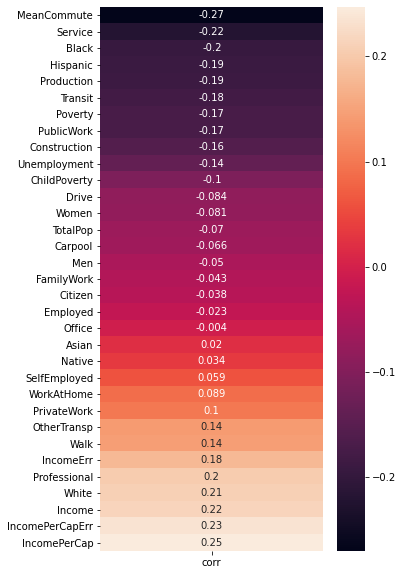

In [314]:
fig, ax = plt.subplots(figsize=(5,10))
ax=sns.heatmap(df_corr,annot=True)

In [315]:
# df_listing_census['Employment']=df_listing_census['Employed']/df_listing_census['Citizen']

In [316]:
# df_rm_outlier=df_listing_census[df_listing_census['price']<1000]
# sns.scatterplot(data=df_rm_outlier, x='IncomePerCap', y='price',alpha=0.1)

In [317]:
# df_rm_outlier=df_listing_census[df_listing_census['price']<1000]
# sns.scatterplot(data=df_rm_outlier, x='MeanCommute', y='price',alpha=0.1)

In [318]:
# sns.boxplot(data=df_rm_outlier, x='IncomePerCap', y='price')

In [320]:
# df_rm_outlier=df_listing_census[df_listing_census['price']<3500]
# sns.scatterplot(data=df_rm_outlier, x='Employment', y='price')

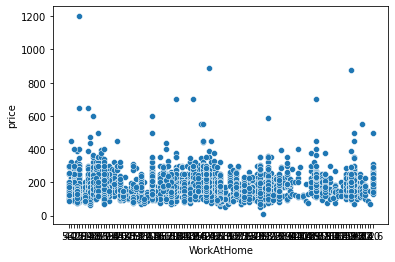

In [321]:
df_rm_outlier=df_listing_census[df_listing_census['price']<3500]
sns.scatterplot(data=df_rm_outlier, x='WorkAtHome', y='price')


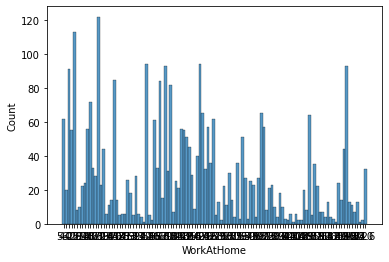

In [322]:
df_rm_outlier=df_listing_census[df_listing_census['price']<3500]
sns.histplot(data=df_listing_census, x='WorkAtHome')


In [323]:
# df_bi=sqlContext.sql('''select Borough, SUM(Income)/SUM(TotalPop) as IncomePerCap, SUM(employed)/SUM(TotalPop) as employment from bi 
#                         group by Borough''')
# df_bi.registerTempTable('bi')
# df_bi.show()

In [324]:
# df_nrp=sqlContext.sql("""select neighbourhood_group_cleansed, room_type, mean(cast(price as float)) as avg_price from nrp
#                 group by neighbourhood_group_cleansed,room_type
#                 order by neighbourhood_group_cleansed,room_type
# """)
# df_np=sqlContext.sql("""select neighbourhood_group_cleansed, mean(cast(price as float)) as avg_price from nrp
#                 group by neighbourhood_group_cleansed
#                 order by avg_price""")
# df_nrp.registerTempTable("nrp")
# df_np.registerTempTable("np")
# df=sqlContext.sql("""select nrp.neighbourhood_group_cleansed, nrp.room_type, bi.IncomePerCap, nrp.avg_price
#                     from nrp 
#                     join bi on bi.Borough == nrp.neighbourhood_group_cleansed
#                     order by nrp.neighbourhood_group_cleansed, nrp.room_type
# """) 

# df2=sqlContext.sql("""select np.neighbourhood_group_cleansed, bi.employment, np.avg_price
#                     from np 
#                     join bi on bi.Borough == np.neighbourhood_group_cleansed
# """) 

In [325]:
df_airbnb_1=sqlContext.sql("""select price, accommodates,bathrooms,beds,
    number_of_reviews,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,
    neighbourhood_group_cleansed,property_type,room_type,bed_type,amenities,latitude,longitude from airbnb""")

In [326]:
df_airbnb_1.show()

+-------+------------+---------+----+-----------------+-----------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+----------------------------+-------------+---------------+--------+--------------------+------------------+------------------+
|  price|accommodates|bathrooms|beds|number_of_reviews|reviews_per_month|review_scores_rating|review_scores_accuracy|review_scores_cleanliness|review_scores_checkin|review_scores_communication|review_scores_location|review_scores_value|neighbourhood_group_cleansed|property_type|      room_type|bed_type|           amenities|          latitude|         longitude|
+-------+------------+---------+----+-----------------+-----------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+----------------------------+-------

In [327]:
df_airbnb_1=df_airbnb_1.dropna()

In [328]:
df_airbnb_1_rdd=df_airbnb_1.rdd.map(lambda x: (x[0][1:].strip().replace(",",""), x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],'_'.join(x[13].split()).strip(),'_'.join(x[14].replace('/','_or_').replace('&','and').split()),'_'.join(x[15].replace('\n', '').replace('/','_or_').split()),'_'.join(x[16].replace('\n', '').replace('/','_or_').replace('-','_').split()),len(x[17][1:-2].split(","))))


In [329]:
df = spark.createDataFrame(df_airbnb_1_rdd).toDF( "price", "accommodates","bathrooms","beds", 
    "number_of_reviews","reviews_per_month","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value",
    "neighbourhood_group_cleansed","property_type","room_type","bed_type","amenities")
df.show(10)

+------+------------+---------+----+-----------------+-----------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+----------------------------+-------------+------------------+--------+---------+
| price|accommodates|bathrooms|beds|number_of_reviews|reviews_per_month|review_scores_rating|review_scores_accuracy|review_scores_cleanliness|review_scores_checkin|review_scores_communication|review_scores_location|review_scores_value|neighbourhood_group_cleansed|property_type|         room_type|bed_type|amenities|
+------+------------+---------+----+-----------------+-----------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+----------------------------+-------------+------------------+--------+---------+
| 60.00|           2|      1.0|   2|             

In [330]:
df_p=df.toPandas()
df_p.head(1)

,price,accommodates,bathrooms,beds,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,neighbourhood_group_cleansed,property_type,room_type,bed_type,amenities
0,60.00,2,1.0,2,41,2.39,99,10,10,10,10,10,10,Bronx,House,Private_room,Real_Bed,5


In [331]:
df_p[['price','bathrooms','reviews_per_month']]=df_p[['price','bathrooms','reviews_per_month']].astype(float)
df_p[['accommodates','beds','number_of_reviews','review_scores_rating','review_scores_accuracy',"review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value"]]=df_p[['accommodates','beds','number_of_reviews','review_scores_rating','review_scores_accuracy',"review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value"]].astype(int)
df_p['price_per_accommodate']=df_p['price']/df_p['accommodates']
var=df_p.columns.to_list()
var=var[-1:]+var[:-1]
df_p=df_p[var]
df_d=pd.get_dummies(data=df_p, columns=["neighbourhood_group_cleansed","property_type","room_type","bed_type"])
df_d.head(10)

,price_per_accommodate,price,accommodates,bathrooms,beds,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,amenities,neighbourhood_group_cleansed_Bronx,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten_Island,property_type_Apartment,property_type_Bed_and_Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper_or_RV,property_type_Castle,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Hut,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt,room_type_Entire_home_or_apt,room_type_Private_room,room_type_Shared_room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull_out_Sofa,bed_type_Real_Bed
0,30.000000,60.0,2,1.0,2,41,2.39,99,10,10,10,10,10,10,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,35.800000,179.0,5,2.5,2,1,0.56,100,10,10,10,10,10,10,16,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,12.250000,49.0,4,1.0,1,36,5.63,97,10,10,10,10,10,10,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,22.000000,88.0,4,1.0,2,35,1.18,96,10,10,10,10,10,10,10,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,32.500000,65.0,2,1.0,1,12,0.93,92,10,9,10,10,10,10,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
5,41.666667,125.0,3,1.0,1,7,1.38,91,10,10,10,10,10,9,14,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
6,27.500000,55.0,2,1.0,2,35,3.54,91,9,9,10,10,9,9,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
7,16.333333,49.0,3,1.0,1,55,1.46,89,9,9,9,9,8,9,3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
8,25.000000,50.0,2,1.0,1,17,0.39,89,10,9,10,10,8,9,11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
9,27.500000,55.0,2,1.5,1,25,1.45,89,9,9,10,10,8,9,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [332]:
df_p.dtypes

price_per_accommodate           float64
price                           float64
accommodates                      int64
bathrooms                       float64
beds                              int64
number_of_reviews                 int64
reviews_per_month               float64
review_scores_rating              int64
review_scores_accuracy            int64
review_scores_cleanliness         int64
review_scores_checkin             int64
review_scores_communication       int64
review_scores_location            int64
review_scores_value               int64
neighbourhood_group_cleansed     object
property_type                    object
room_type                        object
bed_type                         object
amenities                         int64
dtype: object

In [333]:
df_var=df_d.columns[2:].to_frame().rename({0:'variable'},axis=1)
df_corr=df_var.copy()
corr_lst=[]
for i in list(df_d.columns[2:]):
    corr, _ = pearsonr(df_d['price'], df_d[i])
    corr_lst.append(corr)
df_corr['corr']=corr_lst
df_corr=df_corr.loc[:,['corr']]


In [334]:
df_corr=df_corr.sort_values('corr')
df_corr_abs=df_corr.abs().sort_values('corr')
df_corr_abs

,corr
property_type_Villa,0.000505
property_type_Bungalow,0.001102
property_type_Castle,0.001251
property_type_Treehouse,0.001536
property_type_Yurt,0.001996
property_type_Boat,0.002422
property_type_Chalet,0.002524
property_type_Apartment,0.002935
property_type_Other,0.003941
property_type_Hut,0.004958


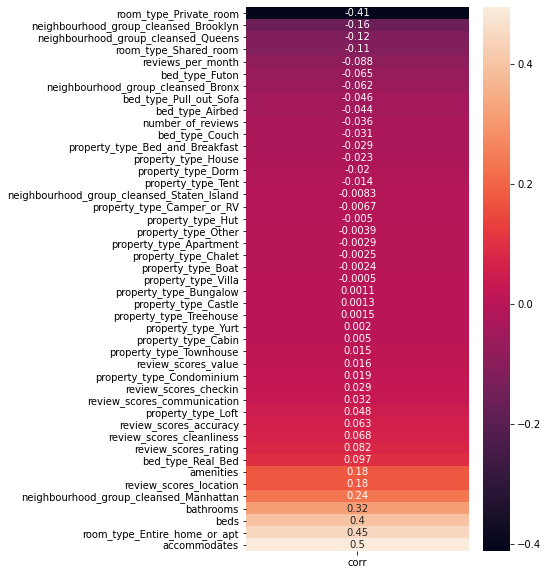

In [335]:
fig, ax = plt.subplots(figsize=(5,10))
ax=sns.heatmap(df_corr,annot=True)
ax.figure.savefig('file.png')

# Distribution

In [336]:
df_d.head(1)

,price_per_accommodate,price,accommodates,bathrooms,beds,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,amenities,neighbourhood_group_cleansed_Bronx,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten_Island,property_type_Apartment,property_type_Bed_and_Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper_or_RV,property_type_Castle,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Hut,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt,room_type_Entire_home_or_apt,room_type_Private_room,room_type_Shared_room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull_out_Sofa,bed_type_Real_Bed
0,30.0,60.0,2,1.0,2,41,2.39,99,10,10,10,10,10,10,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


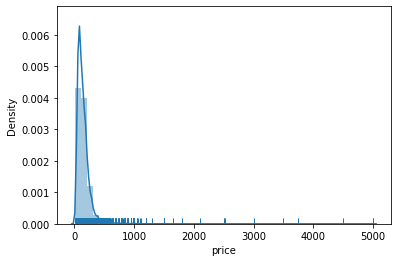

In [337]:
sns.distplot(df_d['price'],rug=True)
df_rm_outlier=df_p[df_p['price']<2000]

(0.0, 1000.0)

<Figure size 432x288 with 0 Axes>

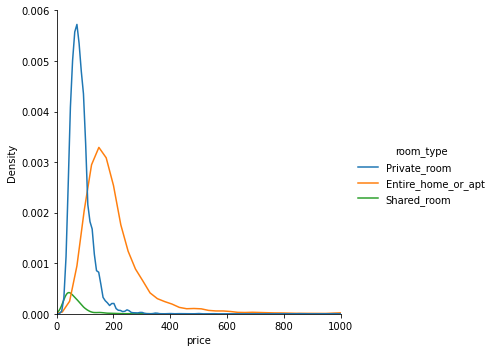

In [338]:
plt.clf()
sns.displot(df_p, x='price',hue='room_type', kind='kde')
plt.xlim(0, 1000)

In [339]:
df_p[df_p['price']<0]

,price_per_accommodate,price,accommodates,bathrooms,beds,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,neighbourhood_group_cleansed,property_type,room_type,bed_type,amenities


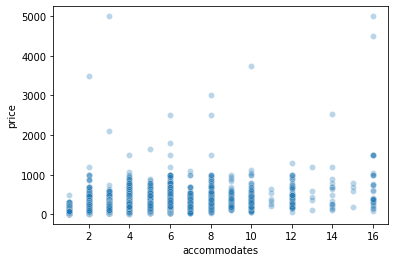

In [340]:
sns.scatterplot(data=df_p,x='accommodates',y='price',alpha=0.3)

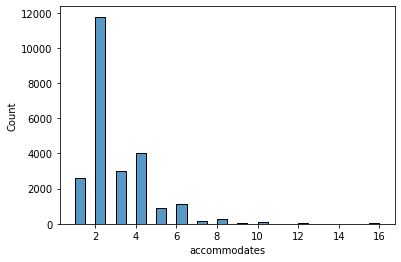

In [341]:
sns.histplot(data=df_p,x='accommodates',binwidth=0.5)

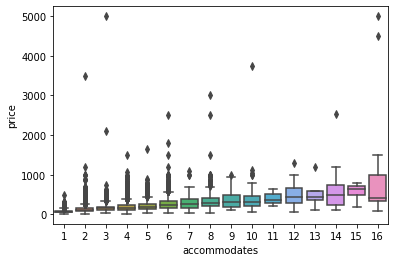

In [342]:

sns.boxplot(data=df_p,x='accommodates',y='price')

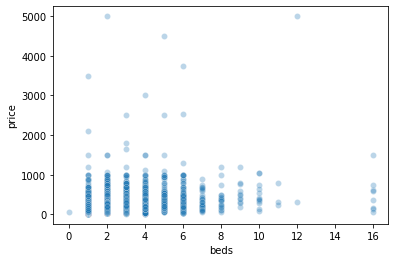

In [343]:
sns.scatterplot(data=df_d,x='beds',y='price',alpha=0.3)

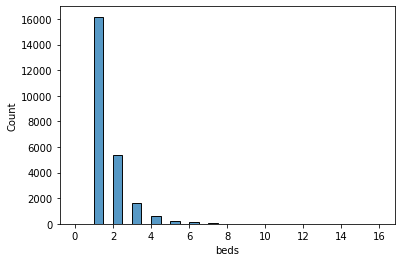

In [344]:
sns.histplot(data=df_p,x='beds',binwidth=0.5)

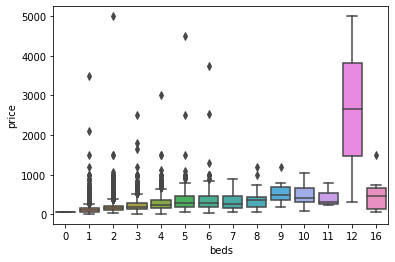

In [345]:

sns.boxplot(data=df_d,x='beds',y='price')

# Review

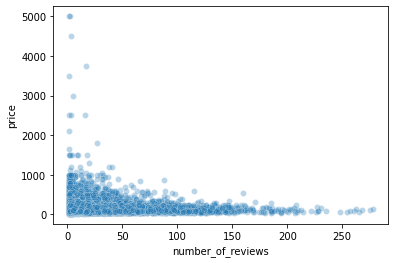

In [346]:
sns.scatterplot(data=df_d,x='number_of_reviews',y='price',alpha=0.3)

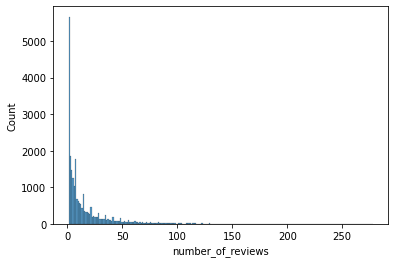

In [347]:
sns.histplot(data=df_p,x='number_of_reviews')

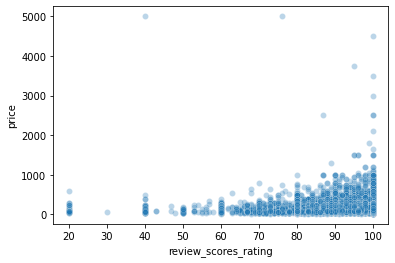

In [348]:
sns.scatterplot(data=df_d,x='review_scores_rating',y='price',alpha=0.3)

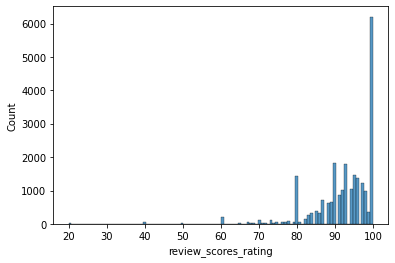

In [349]:
sns.histplot(data=df_p,x='review_scores_rating')

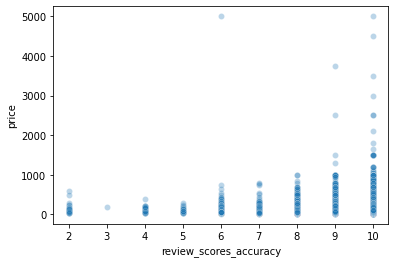

In [350]:
sns.scatterplot(data=df_d,x='review_scores_accuracy',y='price',alpha=0.3)

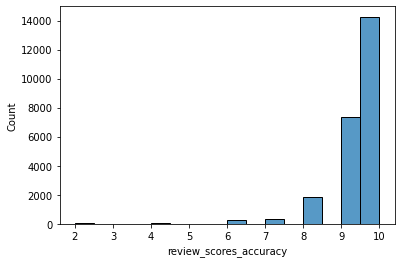

In [351]:
sns.histplot(data=df_p,x='review_scores_accuracy',binwidth=0.5)

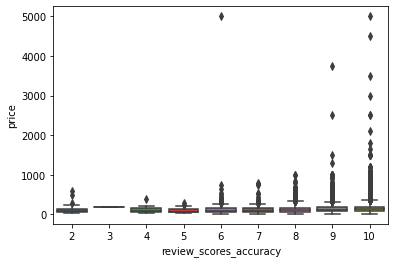

In [352]:
sns.boxplot(data=df_d,x='review_scores_accuracy',y='price')


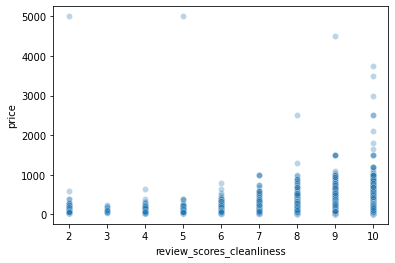

In [353]:
sns.scatterplot(data=df_d,x='review_scores_cleanliness',y='price',alpha=0.3)

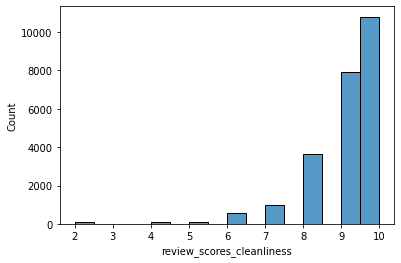

In [354]:
sns.histplot(data=df_p,x='review_scores_cleanliness',binwidth=0.5)

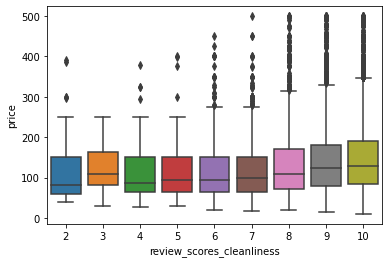

In [355]:
df_rm_outlier=df_p[df_p['price']<500]
sns.boxplot(data=df_rm_outlier,x='review_scores_cleanliness',y='price')

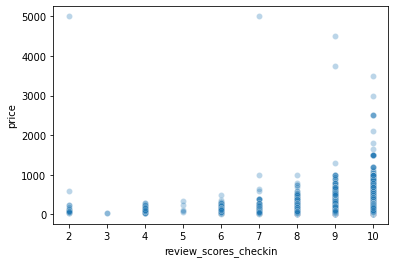

In [356]:
sns.scatterplot(data=df_d,x='review_scores_checkin',y='price',alpha=0.3)

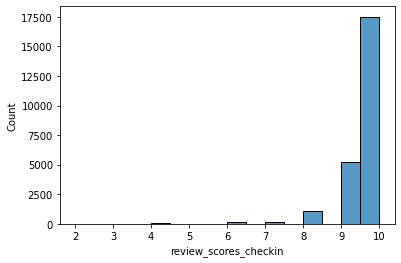

In [357]:
sns.histplot(data=df_p,x='review_scores_checkin',binwidth=0.5)

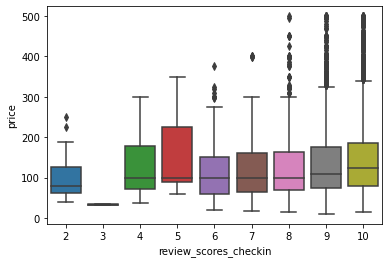

In [358]:
df_rm_outlier=df_p[df_p['price']<500]
sns.boxplot(data=df_rm_outlier,x='review_scores_checkin',y='price')

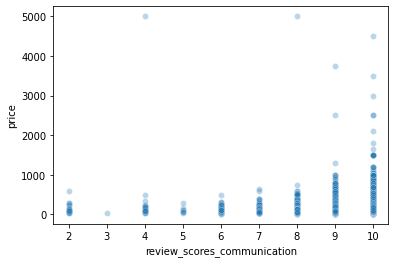

In [359]:
sns.scatterplot(data=df_d,x='review_scores_communication',y='price',alpha=0.3)

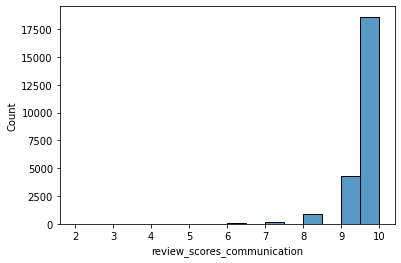

In [360]:
sns.histplot(data=df_p,x='review_scores_communication',binwidth=0.5)

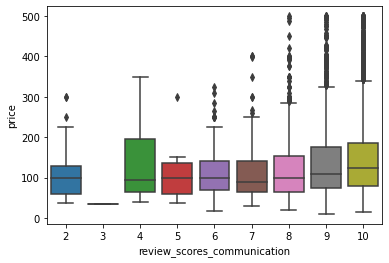

In [361]:
df_rm_outlier=df_p[df_p['price']<500]
sns.boxplot(data=df_rm_outlier,x='review_scores_communication',y='price')

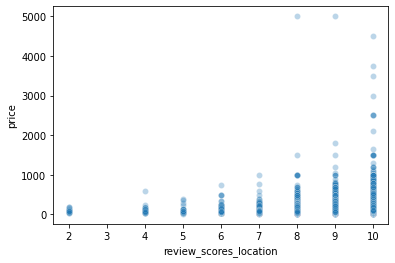

In [362]:
sns.scatterplot(data=df_d,x='review_scores_location',y='price',alpha=0.3)

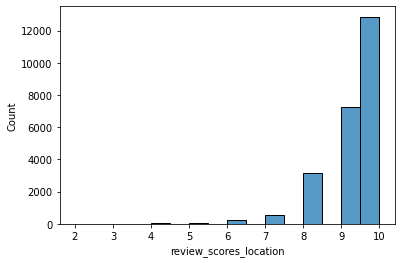

In [363]:
sns.histplot(data=df_p,x='review_scores_location',binwidth=0.5)

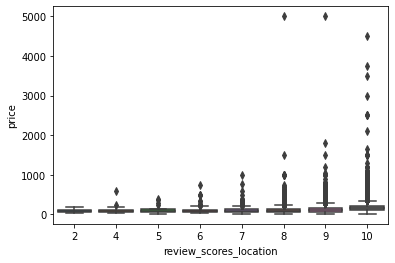

In [364]:
sns.boxplot(data=df_d,x='review_scores_location',y='price')

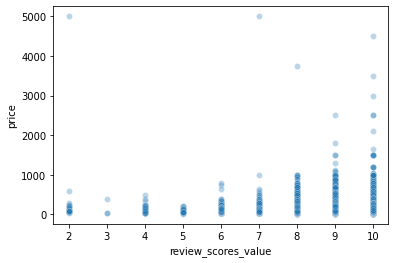

In [365]:
sns.scatterplot(data=df_d,x='review_scores_value',y='price',alpha=0.3)

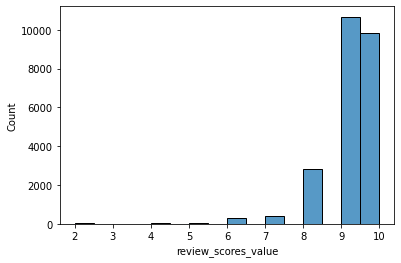

In [366]:
sns.histplot(data=df_p,x='review_scores_value',binwidth=0.5)

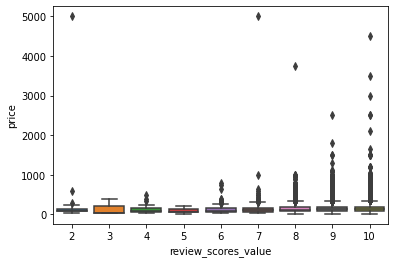

In [367]:
sns.boxplot(data=df_d,x='review_scores_value',y='price')

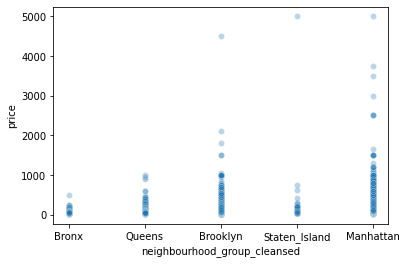

In [368]:
sns.scatterplot(data=df_p,x='neighbourhood_group_cleansed',y='price',alpha=0.3)

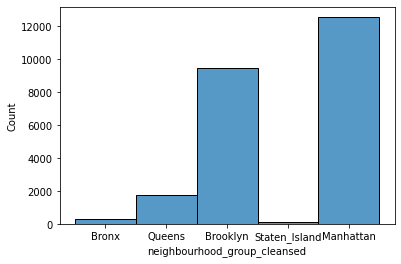

In [369]:
sns.histplot(data=df_p,x='neighbourhood_group_cleansed',binwidth=0.5)

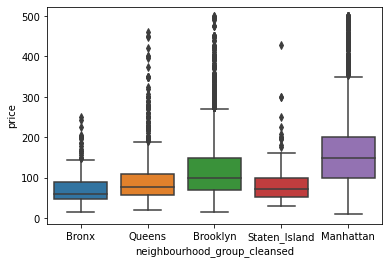

In [370]:
df_rm_outlier=df_p[df_p['price']<500]
sns.boxplot(data=df_rm_outlier,x='neighbourhood_group_cleansed',y='price')

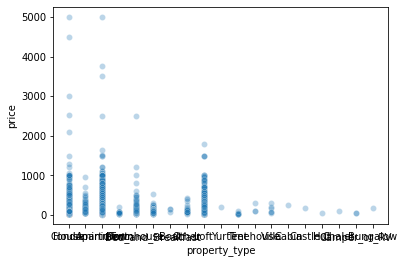

In [371]:
sns.scatterplot(data=df_p,x='property_type',y='price',alpha=0.3)

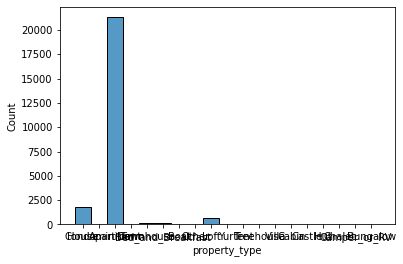

In [372]:
sns.histplot(data=df_p,x='property_type',binwidth=0.5)

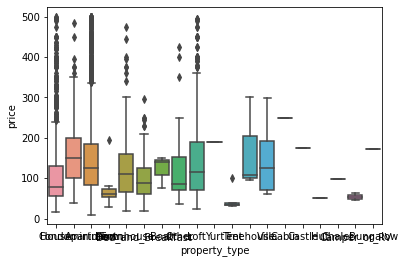

In [373]:
df_rm_outlier=df_p[df_p['price']<500]
sns.boxplot(data=df_rm_outlier,x='property_type',y='price')

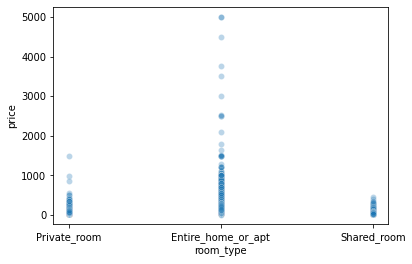

In [374]:
sns.scatterplot(data=df_p,x='room_type',y='price',alpha=0.3)

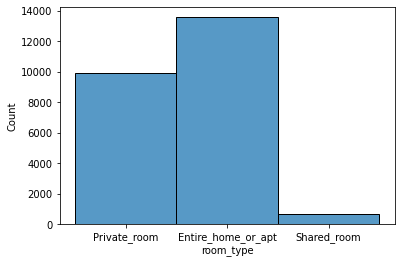

In [375]:
sns.histplot(data=df_p,x='room_type',binwidth=0.5)

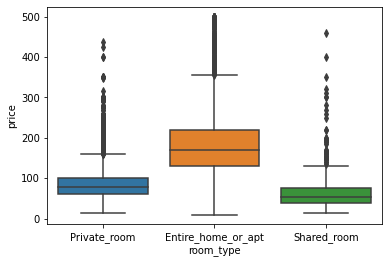

In [376]:
df_rm_outlier=df_p[df_p['price']<500]
sns.boxplot(data=df_rm_outlier,x='room_type',y='price')

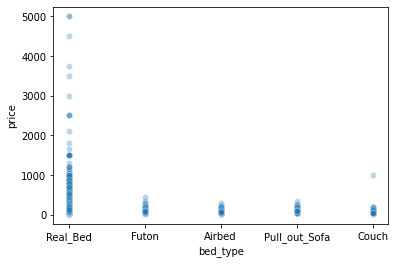

In [377]:
sns.scatterplot(data=df_p,x='bed_type',y='price',alpha=0.3)

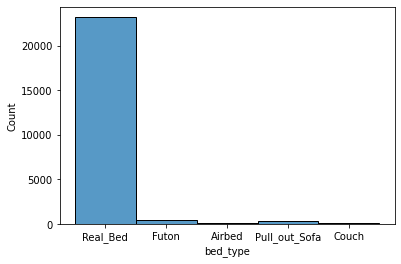

In [378]:
sns.histplot(data=df_p,x='bed_type',binwidth=0.5)

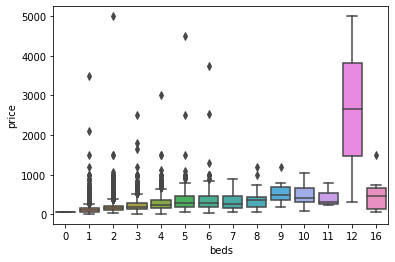

In [379]:
sns.boxplot(data=df_d,x='beds',y='price')

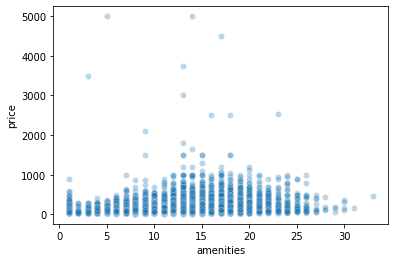

In [380]:
sns.scatterplot(data=df_p,x='amenities',y='price',alpha=0.3)

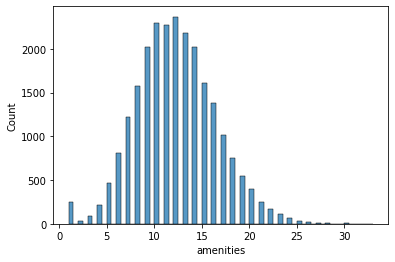

In [381]:
sns.histplot(data=df_p,x='amenities',binwidth=0.5)

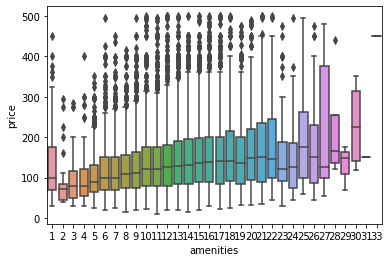

In [382]:
df_rm_outlier=df_p[df_p['price']<500]
sns.boxplot(data=df_rm_outlier,x='amenities',y='price')

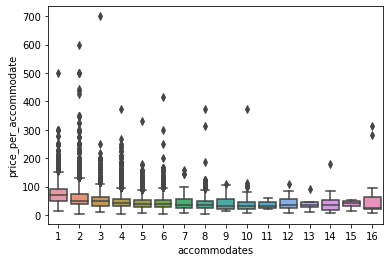

In [383]:
df_rm_outlier=df_p[df_p['price_per_accommodate']<1500]
sns.boxplot(data=df_rm_outlier,x='accommodates',y='price_per_accommodate')

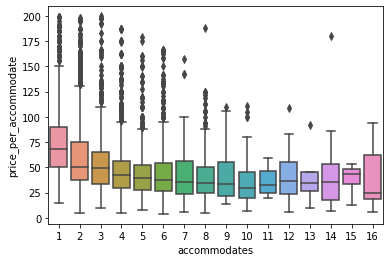

In [384]:
df_rm_outlier=df_p[df_p['price_per_accommodate']<200]
sns.boxplot(data=df_rm_outlier,x='accommodates',y='price_per_accommodate')

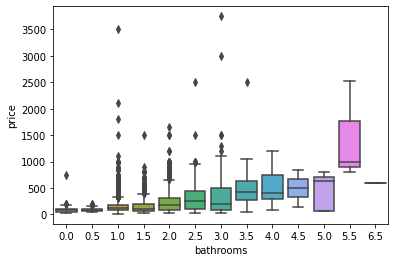

In [385]:
df_rm_outlier=df_p[df_p['price']<4000]
sns.boxplot(data=df_rm_outlier,x='bathrooms',y='price')

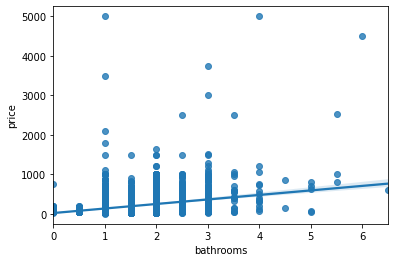

In [399]:
sns.regplot(x='bathrooms',y='price', data=df_p)

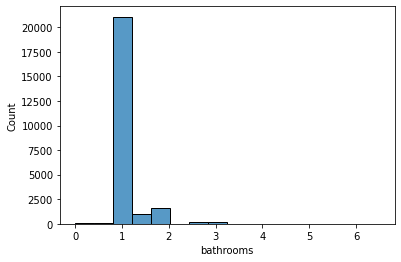

In [386]:
sns.histplot(data=df_d,x='bathrooms')

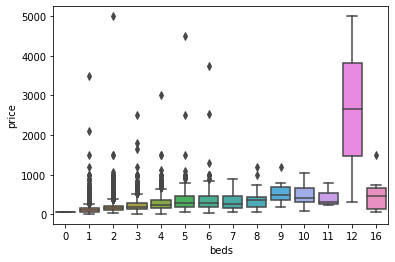

In [387]:
df_rm_outlier=df_p[df_p['price_per_accommodate']<200]

sns.boxplot(data=df_d,x='beds',y='price')

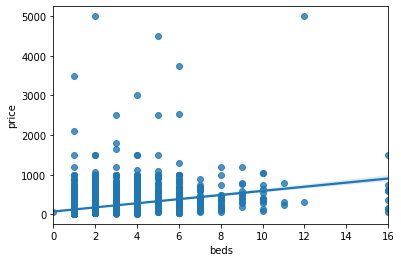

In [398]:
sns.regplot(x='beds',y='price', data=df_p)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


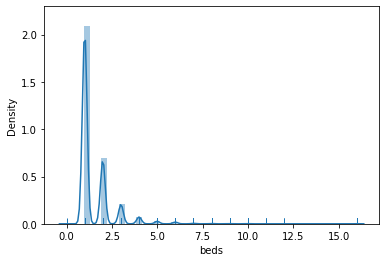

In [388]:
sns.distplot(df_d['beds'],rug=True)

# Amenities

In [389]:
df_d.shape

(24181, 47)

In [390]:
df_l=df_p[df_p.columns[2:]]

# Regression


In [391]:
model = smf.ols(f"price ~ {'+'.join(df_corr_abs.index.tolist()[15:])}", data=df_d).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     639.5
Date:                Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:14:52   Log-Likelihood:            -1.4521e+05
No. Observations:               24181   AIC:                         2.905e+05
Df Residuals:                   24152   BIC:                         2.907e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                               -119.4752      9.216    -12.963      0.000    -137.540    -101.410
review_scores_value                      -14.3148      1.106    -12.943      0.000     -16.483     -12.147
property_type_Condominium                 12.9971     10.511      1.236      0.216      -7.606      33.600
property_type_Dorm                         7.0466     20.565      0.343      0.732     -33.261      47.354
property_type_House                        5.4134      2.643      2.048      0.041       0.233      10.593
property_type_Bed_and_Breakfast           -2.5244      8.551     -0.295      0.768     -19.285      14.236
review_scores_checkin                     -3.0082      1.158     -2.597      0.009      -5.279      -0.738
bed_type_Couch                           -20.3252      9.295     -2.187      0.029     -38.543      -2.107
review_scores_communication               -3.2256      1.270     -2.539      0.011      -5.716      -0.736
number_of_reviews                         -0.0711      0.029     -2.477      0.013      -0.127      -0.015
bed_type_Airbed                          -29.1576      7.111     -4.100      0.000     -43.096     -15.219
bed_type_Pull_out_Sofa                   -23.5946      5.523     -4.272      0.000     -34.419     -12.770
property_type_Loft                        40.3468      3.922     10.289      0.000      32.660      48.033
neighbourhood_group_cleansed_Bronx       -14.7253     10.479     -1.405      0.160     -35.264       5.814
review_scores_accuracy                     2.7795      1.040      2.674      0.008       0.742       4.817
bed_type_Futon                           -26.2964      5.054     -5.204      0.000     -36.202     -16.391
review_scores_cleanliness                  3.2579      0.812      4.014      0.000       1.667       4.849
review_scores_rating                       0.9421      0.141      6.675      0.000       0.665       1.219
reviews_per_month                         -6.6018      0.565    -11.688      0.000      -7.709      -5.495
bed_type_Real_Bed                        -20.1014      3.432     -5.857      0.000     -26.828     -13.374
room_type_Shared_room                    -71.8561      4.062    -17.690      0.000     -79.818     -63.895
neighbourhood_group_cleansed_Queens      -14.4424      8.938     -1.616      0.106     -31.962       3.077
neighbourhood_group_cleansed_Brooklyn     -5.1974      8.733     -0.595      0.552     -22.314      11.919
amenities                                  1.6203      0.159     10.189      0.000       1.309       1.932
review_scores_location                    18.8067      0.807     23.297      0.000      17.224      20.389
neighbourhood_group_cleansed_Manhattan    43.9178      8.766      5.010      0.000     

In [421]:
# df_rm_outlier=df_rm_outlier[df_rm_outlier['price_per_accommodate']<16]
# df_rm_outlier=df_d[df_d['price_per_accommodate']<100]
# df_rm_outlier=df_d[df_d['price_per_accommodate']<16]
df_rm_outlier=df_d[df_d['price']<1200]
# df_rm_outlier=df_rm_outlier[df_rm_outlier['beds']<12]
model = smf.ols(f"price ~ {'+'.join(df_rm_outlier.columns[2:])}", data=df_rm_outlier[1:]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     703.6
Date:                Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:17:01   Log-Likelihood:            -1.3704e+05
No. Observations:               24156   AIC:                         2.742e+05
Df Residuals:                   24114   BIC:                         2.745e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                    -91.3253      7.327    -12.465      0.000    -105.686     -76.965
accommodates                                  19.2386      0.505     38.086      0.000      18.248      20.229
bathrooms                                     58.7788      1.423     41.318      0.000      55.990      61.567
beds                                           2.6567      0.806      3.294      0.001       1.076       4.237
number_of_reviews                             -0.0624      0.021     -3.022      0.003      -0.103      -0.022
reviews_per_month                             -5.6715      0.407    -13.947      0.000      -6.469      -4.874
review_scores_rating                           0.7641      0.101      7.540      0.000       0.565       0.963
review_scores_accuracy                         0.2776      0.747      0.372      0.710      -1.186       1.741
review_scores_cleanliness                      4.3283      0.583      7.423      0.000       3.185       5.471
review_scores_checkin                          0.4141      0.833      0.497      0.619      -1.218       2.046
review_scores_communication                   -2.2289      0.912     -2.443      0.015      -4.017      -0.441
review_scores_location                        16.9058      0.580     29.146      0.000      15.769      18.043
review_scores_value                          -12.4021      0.795    -15.609      0.000     -13.959     -10.845
amenities                                      1.9787      0.114     17.310      0.000       1.755       2.203
neighbourhood_group_cleansed_Bronx           -29.6069      3.979     -7.440      0.000     -37.406     -21.807
neighbourhood_group_cleansed_Brooklyn        -18.3811      2.108     -8.720      0.000     -22.513     -14.249
neighbourhood_group_cleansed_Manhattan        27.9599      2.138     13.077      0.000      23.769      32.151
neighbourhood_group_cleansed_Queens          -28.4167      2.408    -11.799      0.000     -33.137     -23.696
neighbourhood_group_cleansed_Staten_Island   -42.8805      5.404     -7.935      0.000     -53.473     -32.288
property_type_Apartment                      -20.2673      9.940     -2.039      0.041     -39.750      -0.784
property_type_Bed_and_Breakfast              -20.9336     11.489     -1.822      0.068     -43.454       1.586
property_type_Boat                           -39.9641     39.824     -1.004      0.316    -118.022      38.093
property_type_Bungalow                        40.9588     67.539      0.606      0.544     -91.422     173.340
property_type_Cabin                           27.1060     67.510      0.402      0.688    -105.218     159.430
property_type_Camper_or_RV                   -39.9137     48.255     -0.827      0.408

In [393]:
df_corr_abs.index.tolist()[15:]

['review_scores_value',
 'property_type_Condominium',
 'property_type_Dorm',
 'property_type_House',
 'property_type_Bed_and_Breakfast',
 'review_scores_checkin',
 'bed_type_Couch',
 'review_scores_communication',
 'number_of_reviews',
 'bed_type_Airbed',
 'bed_type_Pull_out_Sofa',
 'property_type_Loft',
 'neighbourhood_group_cleansed_Bronx',
 'review_scores_accuracy',
 'bed_type_Futon',
 'review_scores_cleanliness',
 'review_scores_rating',
 'reviews_per_month',
 'bed_type_Real_Bed',
 'room_type_Shared_room',
 'neighbourhood_group_cleansed_Queens',
 'neighbourhood_group_cleansed_Brooklyn',
 'amenities',
 'review_scores_location',
 'neighbourhood_group_cleansed_Manhattan',
 'bathrooms',
 'beds',
 'room_type_Private_room',
 'room_type_Entire_home_or_apt',
 'accommodates']

In [394]:
df_p.columns.tolist()[

SyntaxError: ignored

In [ ]:

model = smf.ols(f"price ~ {'+'.join(df_p.columns.tolist()[2:])}", data=df_p[df_p.columns[1:]]).fit()
model.summary()


In [ ]:

model = smf.ols(f"price ~ {'+'.join(df_rm_outlier.columns.tolist())}", data=df_rm_outlier).fit()
model.summary()


In [ ]:
df_pvalue=model.pvalues.reset_index().rename({0:'p_value','index':'variable'},axis=1)

variable=df_pvalue[df_pvalue['p_value']<0.05].variable
variable

In [ ]:
model1 = smf.ols(f"price ~ {'+'.join(variable.tolist()[1:])}", data=df_d).fit()
model1.summary()

# Machine Learning


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [ ]:
x=df_d[df_corr_abs.index[:]]
y=df_d.loc[:,['price']]
X_train, X_test, y_train, y_test = train_test_split(
     x, y, test_size=.3, random_state=0)
reg=LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_train, y_train)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
reg.score(y_train, y_test)

In [ ]:
y_predict=y_test.copy()
y_predict['price']=reg.predict(X_test)
reg.score(X_train, y_train)

In [ ]:
resid=y_predict['price']-X_test

In [ ]:
df_d.columns[2:].tolist()

In [ ]:
model=KNeighborsClassifier()
model=model.fit(X_train, y_train.values.ravel())
accuracy_score(y_test, model.predict(X_test))

In [ ]:
model=KNeighborsClassifier(n_neighbors=6,weights='distance',algorithm='ball_tree',leaf_size=140,p=1)
model=model.fit(X_train, y_train.values.ravel())
accuracy_score(y_test, model.predict(X_test))

In [ ]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(60,151,20))
n_neighbors = [6]
p=[1]
algorithm=['ball_tree']
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p,algorithm=algorithm)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train, y_train.values.ravel())
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

In [ ]:
print(
accuracy_score(y_test, best_model.predict(X_test)),
# recall_score(y_test, model.predict(X_test),average='micro'),
# precision_score(y_test, model.predict(X_test),average='micro')
)

In [ ]:
# confusion matrix shows the all results by how they were classified
plot_confusion_matrix(model, X_test, y_test,
                         cmap=plt.cm.Blues)